## Predicting failures from age and temperature data

Let's suppose that our hypothesis is that the failure rate is tied to the age of the pipes (as given by the install year) and the temperature in some way.

We're going to struggle to analyse the full dataset easily so we're going to bin things up a bit to make the datasets smaller. Hopefully there's still an interesting signal!

The first thing we'll do is aggregate suburb names up to postcode level. Then we'll use Australia Post postcode data to generate latitudes and longitudes. Then we'll use `bomber` - a library I wrote to download monthly temperature maximums and extract the temperatures for each postcode for each month from 2010 to 2016.

Finally we'll join the postcode level temperature and age info back onto our failure data to look at whether there's something useful to predict.

### Reading in age data

First we're going to look at the pipe age data from ATCO. This one is much tidier than the faults data.

In [5]:
import pandas as pd
import seaborn
import numpy as np
from os import path

seaborn.set()

# Setting where our data is sitting
data_folder = path.join(
    path.abspath('..'),  # '..' means the directory above this one
    'data')
data_folder

'/Users/jess/Documents/Core - Data Science Workshop/repositories/01-zero-to-data-science/data'

In [6]:
age_file = path.join(data_folder, 'Mains_Age_Profile_Estimation 250516.xlsm')
age_xl = pd.ExcelFile(age_file)
age_xl.sheet_names

['Earliest Mains by Suburbs',
 'ArcFM Data',
 'Filtered Fields',
 'Pivot',
 'Suburb_Age_Length_Material',
 'HP Age Profile',
 'Age Profile Chart',
 'Mean PVC Age Profile']

Next we can parse the data

In [7]:
age_data = age_xl.parse('ArcFM Data')

# rename columns so we aren't yelling all the time
new_names = {
    'INSTALLATI': 'installation',
    'Year': 'year',
    'NOMINALDIA': 'nominal_diameter',
    'ACTUALINTE': 'actual_interior_diameter',
    'MATERIAL': 'material',
    'MEASUREDLE': 'measured_length',
    'MOAP': 'moap',
    'GAS_TYPE': 'gas_type',
    'DIST_LEVEL': 'dist_level',
    'MATERIAL_T': 'material_type',
    'PIPE_NAME': 'pipe_name',
    'SUBURB': 'suburb',
    'POSTCODE': 'postcode',
    'SHAPE_LEN': 'mapped_length'
}
age_data.rename(columns=new_names, inplace=True)

# there are some strange numbers in the age data - we just clip these to 2018
age_data.year = np.clip(age_data.year, age_data.year.min(), 2018)

# Let's see what we've got
age_data.year.describe()

count    559101.000000
mean       1996.216068
std           6.155449
min        1900.000000
25%        1992.000000
50%        1993.000000
75%        1998.000000
max        2018.000000
Name: year, dtype: float64

The next step is to generate quantiles for age for each postcode. We do this by iterating over the records and generating the quantiles row by row (there's probably better ways to do this but we're running towards getting something up at the moment)

In [8]:
features = pd.DataFrame.from_records([
        (postcode, df.year.min(), df.year.quantile(0.25), df.year.median(), 
                    df.year.quantile(0.75), df.year.max())
        for postcode, df in age_data.groupby('postcode')
    ], 
    columns=('postcode', 'q0', 'q25', 'q50', 'q75', 'q100'),
    index='postcode'
)

features.head()

,q0,q25,q50,q75,q100
postcode,,,,,
0,1991.0,1991.0,1993.0,1993.0,2012.0
6000,1991.0,1993.0,1993.0,1994.0,2013.0
6003,1993.0,1993.0,1994.0,1995.0,2011.0
6004,1986.0,1993.0,1993.0,1995.0,2018.0
6005,1993.0,1994.0,1994.0,1998.0,2013.0


Now we can take the postcode data and use this to extract a latitude and longitude for each postcode. We're using an inner join on the postcode indices to only get the values we care about

In [9]:
raw_postcodes = pd.read_csv(path.join(data_folder, 'australian_postcodes.csv'))

# We have to remove duplicate records (there's one for each suburb) so we aggregate them up
postcodes = pd.DataFrame.from_records([
        (postcode, df.long.mean(), df.lat.mean(), ', '.join(df.locality))
        for postcode, df in raw_postcodes.dropna(how='any').groupby('postcode')
    ],
    columns=('postcode', 'longitude', 'latitude', 'locality'),
    index='postcode'
)

Now we can join the two tables together to get one table with all the relevant information

In [10]:
features = features.join(postcodes, how='inner')

and we can see the spread of postcodes around Perth with a quick scatter plot

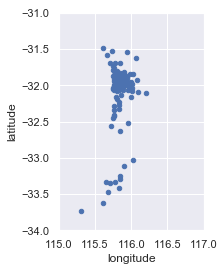

In [11]:
ax = features.plot('longitude', 'latitude', kind='scatter')
ax.set_xlim(115, 117)
ax.set_ylim(-34, -31)
ax.set_aspect(1)

### Downloading temperature data

We're going to use bomber to do the download

In [13]:
import bomber

bomber.measurements.DATASETS

{'temperature': ['maxave', 'minave'],
 'rainfall': ['totals'],
 'vprp': ['vprp09', 'vprp15'],
 'solar': ['solarave'],
 'ndvi': ['ndviave']}

In [14]:
bomber.get_measurements(
    dataset='temperature', 
    variable='maxave',
    year=2010,
    month=1
)

FileNotFoundError: [Errno 2] No such file or directory: 'temperature_maxave_month_2010010120100131'

In [ ]:
bomber.grid_to_geotiff